# Test Degree PINNs 3D

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans le TestCase1 3D.

On cherche à tester la correction à $N$ fixé mais pour un deg_PINNs qui varient.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem_3D import FEMSolver
from modules.utils import create_tree
from modules.fenics_expressions import UexExpr

/home/u2/lecourtier/miniconda3/envs/test_phifem/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using device: cpu


In [4]:
if testcase == 1:
    from modules.testcases.d3.test_1.test_1_v1 import Run_laplacian3D,Poisson_3D
    from modules.problem_3D import TestCase1_3D
    problem = TestCase1_3D()
else:
    raise ValueError("Testcase not found")

result_dir = "../../results/testcase"+str(testcase)+"_3D"
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/degPINNs/"
create_tree(result_dir)

torch loaded; device is cpu


>> load network /home/u2/lecourtier/Article1/networks/test_fe1_3D.pth
jsbdbshd
network loaded
 >>> 2.955130100250244


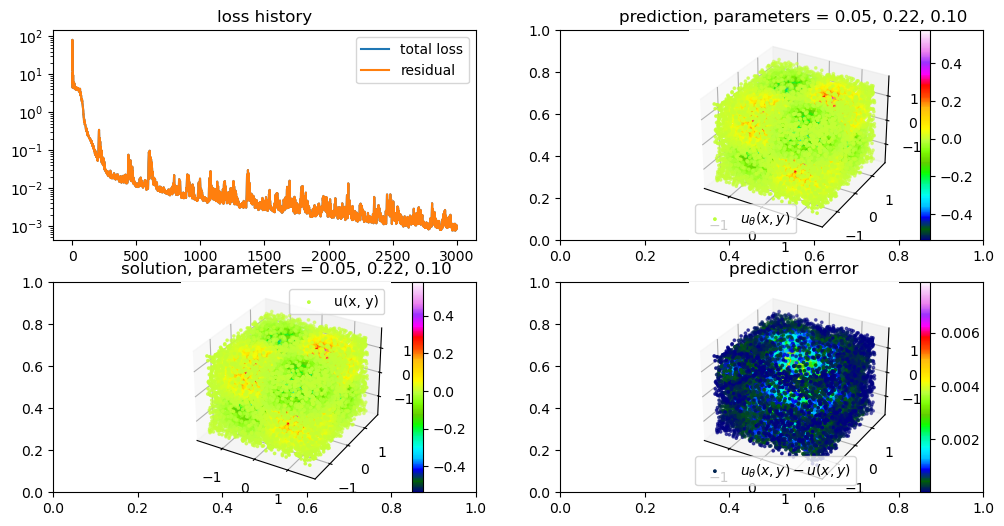

In [5]:
pde = Poisson_3D()
trainer,u_theta = Run_laplacian3D(pde)

In [6]:
def get_param(i):
    params = problem.parameter_domain
    # params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1]), np.random.uniform(params[2][0], params[2][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22 0.1 ]


## Convergence PINNs+Corr

In [7]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [8]:
nb_vert = 20

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_degree_PINNs = list(df_Corr['degree_PINNs'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    tab_times_Corr = list(df_Corr['times'].values)
    tab_subtimes_Corr = {}
    for key in df_Corr.keys():
        if key not in ['degree_PINNs', 'err', 'times']:
            tab_subtimes_Corr[key] = list(df_Corr[key].values)
    
    return df_Corr, tab_degree_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr, tab_degree_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_degree_PINNs = [3,4,5,6]
        tab_err_Corr = []
        tab_times_Corr = []
        tab_subtimes_Corr = {}
        
        for degree_PINNs in tab_degree_PINNs:
            print("#### deg_PINNs = ",degree_PINNs)
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            u_ex = UexExpr(params[0], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                
            uref_Vex = df.interpolate(u_ex,V_test)
            norme_L2_PINNs = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"nb_vert={nb_vert}, norme_L2_PINNs={norme_L2_PINNs}")
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)

            times_Corr = solver.times_corr_add
            for key in times_Corr:
                if key in tab_subtimes_Corr:
                    tab_subtimes_Corr[key].append(times_Corr[key])
                else:
                    tab_subtimes_Corr[key] = [times_Corr[key]]
            print(times_Corr.values())
            times_Corr.__delitem__("system")
            total = sum(times_Corr.values())
            print(f"total time: {total}")
            tab_times_Corr.append(total)
        
        df_Corr = pd.DataFrame({'degree_PINNs': tab_degree_PINNs, 'err': tab_err_Corr, 'times': tab_times_Corr, **tab_subtimes_Corr})       
        df_Corr.to_csv(csv_file, index=False)  
            
    return df_Corr, tab_degree_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

In [9]:
degree = 1
df_Corr, tab_degree_PINNs, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = run_Corr(degree)

Read csv file ../../results/testcase1_3D/degPINNs/Corr_case1_param1_degree1.csv


In [10]:
df_Corr_ = df_Corr.copy()
df_Corr_ = df_Corr_.rename(columns={"times": "TOTAL"})


In [11]:
df_Corr_.reindex(columns = ["degree_PINNs","err","mesh","assemble_A","assemble_b","impose_BC","system","solve","TOTAL"])

,degree_PINNs,err,mesh,assemble_A,assemble_b,impose_BC,system,solve,TOTAL
0,3,0.009271,0.002169,0.016869,52.881422,0.004924,52.903218,0.243906,53.149290
1,4,0.000663,0.001783,0.017459,91.585155,0.005533,91.608148,0.306064,91.915994
2,5,0.000768,0.002006,0.016981,146.027950,0.005255,146.050188,0.299739,146.351931
3,6,0.000748,0.001865,0.017437,218.949996,0.005225,218.972660,0.285064,219.259589
